In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
historical_temps = pd.read_csv('preds_1880-1960.csv')
# this is the file we created by running our `fully_connected_1960.ipynb` on data observations in the range 1880 - 1960
historical_temps = historical_temps.drop('Unnamed: 0', axis=1)
historical_temps

,year,temp_anom,pred
0,1880,-0.580696,-0.319498
1,1881,-0.437284,-0.322879
2,1882,-0.448660,-0.311360
3,1883,-0.535872,-0.312129
4,1884,-0.577859,-0.296652
...,...,...,...
75,1955,-0.628892,0.479466
76,1956,-0.655931,0.500699
77,1957,-0.272213,0.523098
78,1958,-0.251039,0.544479


We will run an RNN for both the NOAA `temp_anom`s and our own predicted `pred` temperature anomalies. Then, we will see how similar/different those predictions are.

In [52]:
# flip the arrays so that they're goin in reverse order, and will thus predict the past rather than the future
coral_temp_anoms = np.flip(np.array(historical_temps['pred']), axis=None)
noaa_temp_anoms = np.flip(np.asarray(historical_temps['temp_anom']))
coral_temp_anoms[:5], noaa_temp_anoms[:5]

(array([0.56901944, 0.54447895, 0.5230977 , 0.50069875, 0.47946632]),
 array([-0.22745812, -0.25103928, -0.27221271, -0.65593149, -0.62889203]))

In [53]:
len(coral_temp_anoms), len(noaa_temp_anoms)

(80, 80)

Predict the next annual temp anomaly based off of the previous 4.

In [54]:
N = 80  # total unmber of records
Tp = 65 # train on 65 records, test on 15

In [55]:
coral_train, coral_test = coral_temp_anoms[0:Tp], coral_temp_anoms[Tp:N]
noaa_train, noaa_test = noaa_temp_anoms[0:Tp], noaa_temp_anoms[Tp:N]

In [56]:
len(coral_train), len(coral_test)

(65, 15)

In [57]:
step = 4
# add step elements into train and test
coral_test = np.append(coral_test,np.repeat(coral_test[-1,],step))
coral_train = np.append(coral_train,np.repeat(coral_train[-1,],step))

noaa_test = np.append(noaa_test,np.repeat(noaa_test[-1,],step))
noaa_train = np.append(noaa_train,np.repeat(noaa_train[-1,],step))

In [58]:
# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

coral_trainX, coral_trainY = convertToMatrix(coral_train,step)
coral_testX, coral_testY = convertToMatrix(coral_test,step)

noaa_trainX, noaa_trainY = convertToMatrix(noaa_train,step)
noaa_testX, noaa_testY = convertToMatrix(noaa_test,step)

In [59]:
coral_trainX = np.reshape(coral_trainX, (coral_trainX.shape[0], 1, coral_trainX.shape[1]))
coral_testX = np.reshape(coral_testX, (coral_testX.shape[0], 1, coral_testX.shape[1]))
coral_testX.shape

(15, 1, 4)

In [60]:
noaa_trainX = np.reshape(noaa_trainX, (noaa_trainX.shape[0], 1, noaa_trainX.shape[1]))
noaa_testX = np.reshape(noaa_testX, (noaa_testX.shape[0], 1, noaa_testX.shape[1]))
noaa_testX.shape

(15, 1, 4)

In [61]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense

In [62]:
# SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit(coral_trainX,coral_trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(coral_trainX)
testPredict= model.predict(coral_testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

Epoch 1/100
5/5 - 1s - loss: 0.0738
Epoch 2/100
5/5 - 0s - loss: 0.0539
Epoch 3/100
5/5 - 0s - loss: 0.0431
Epoch 4/100
5/5 - 0s - loss: 0.0355
Epoch 5/100
5/5 - 0s - loss: 0.0292
Epoch 6/100
5/5 - 0s - loss: 0.0225
Epoch 7/100
5/5 - 0s - loss: 0.0209
Epoch 8/100
5/5 - 0s - loss: 0.0191
Epoch 9/100
5/5 - 0s - loss: 0.0176
Epoch 10/100
5/5 - 0s - loss: 0.0159
Epoch 11/100
5/5 - 0s - loss: 0.0148
Epoch 12/100
5/5 - 0s - loss: 0.0136
Epoch 13/100
5/5 - 0s - loss: 0.0125
Epoch 14/100
5/5 - 0s - loss: 0.0110
Epoch 15/100
5/5 - 0s - loss: 0.0101
Epoch 16/100
5/5 - 0s - loss: 0.0091
Epoch 17/100
5/5 - 0s - loss: 0.0082
Epoch 18/100
5/5 - 0s - loss: 0.0071
Epoch 19/100
5/5 - 0s - loss: 0.0059
Epoch 20/100
5/5 - 0s - loss: 0.0054
Epoch 21/100
5/5 - 0s - loss: 0.0049
Epoch 22/100
5/5 - 0s - loss: 0.0044
Epoch 23/100
5/5 - 0s - loss: 0.0038
Epoch 24/100
5/5 - 0s - loss: 0.0033
Epoch 25/100
5/5 - 0s - loss: 0.0028
Epoch 26/100
5/5 - 0s - loss: 0.0023
Epoch 27/100
5/5 - 0s - loss: 0.0019
Epoch 28/1

In [64]:
#Next, we'll check the loss
trainScore = model.evaluate(coral_trainX, coral_trainY, verbose=0)
print(trainScore)

1.3601122191175818e-05


In [65]:
# put them in the right order again
predicted = np.flip(predicted)

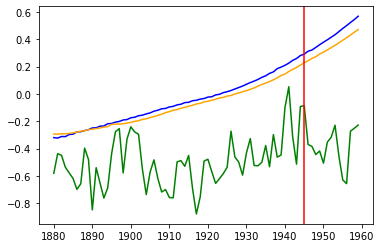

In [66]:
# Finally, we check the result in a plot. 
# A vertical line in a plot identifies a splitting point between the training and the test part.
index = historical_temps['year'].values
plt.plot(index,historical_temps['pred'], color = 'blue')
plt.plot(index,historical_temps['temp_anom'], color = 'green')
plt.plot(index,predicted, color="orange")
plt.axvline(historical_temps['year'][Tp], c="r")
plt.show() 

In [67]:
model.fit(noaa_trainX,noaa_trainY, epochs=100, batch_size=16, verbose=2)
trainPredict_noaa = model.predict(noaa_trainX)
testPredict_noaa= model.predict(noaa_testX)
predicted_noaa=np.concatenate((trainPredict_noaa,testPredict_noaa),axis=0)

Epoch 1/100
5/5 - 0s - loss: 0.0201
Epoch 2/100
5/5 - 0s - loss: 0.0197
Epoch 3/100
5/5 - 0s - loss: 0.0198
Epoch 4/100
5/5 - 0s - loss: 0.0194
Epoch 5/100
5/5 - 0s - loss: 0.0201
Epoch 6/100
5/5 - 0s - loss: 0.0200
Epoch 7/100
5/5 - 0s - loss: 0.0191
Epoch 8/100
5/5 - 0s - loss: 0.0198
Epoch 9/100
5/5 - 0s - loss: 0.0191
Epoch 10/100
5/5 - 0s - loss: 0.0197
Epoch 11/100
5/5 - 0s - loss: 0.0188
Epoch 12/100
5/5 - 0s - loss: 0.0187
Epoch 13/100
5/5 - 0s - loss: 0.0193
Epoch 14/100
5/5 - 0s - loss: 0.0187
Epoch 15/100
5/5 - 0s - loss: 0.0192
Epoch 16/100
5/5 - 0s - loss: 0.0196
Epoch 17/100
5/5 - 0s - loss: 0.0184
Epoch 18/100
5/5 - 0s - loss: 0.0191
Epoch 19/100
5/5 - 0s - loss: 0.0187
Epoch 20/100
5/5 - 0s - loss: 0.0194
Epoch 21/100
5/5 - 0s - loss: 0.0187
Epoch 22/100
5/5 - 0s - loss: 0.0196
Epoch 23/100
5/5 - 0s - loss: 0.0181
Epoch 24/100
5/5 - 0s - loss: 0.0186
Epoch 25/100
5/5 - 0s - loss: 0.0192
Epoch 26/100
5/5 - 0s - loss: 0.0200
Epoch 27/100
5/5 - 0s - loss: 0.0182
Epoch 28/1

In [68]:
#Next, we'll check the loss
trainScore = model.evaluate(noaa_trainX, noaa_trainY, verbose=0)
print(trainScore)

0.015891747549176216


In [69]:
# put them in the right order again
predicted_noaa = np.flip(predicted_noaa)

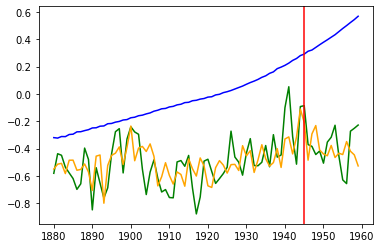

In [70]:
# Finally, we check the result in a plot. 
# A vertical line in a plot identifies a splitting point between the training and the test part.
index = historical_temps['year'].values
plt.plot(index,historical_temps['pred'], color = 'blue')
plt.plot(index,historical_temps['temp_anom'], color = 'green')
plt.plot(index,predicted_noaa, color="orange")
plt.axvline(historical_temps['year'][Tp], c="r")
plt.show() 